Phys474 - Spring 2023

Lab 3 - The Time Dependent Schrodinger Equation 

<font color='red'>Author: Valery Simonyan

In this lab you will gain practice in calculating the TDSE for various potentials. In particular we will examine the scattering of a guassian wave packet from 
- Step Potential
- Barrier Potential

The Schrodinger equation is given by

$i\hbar\frac{\partial\Psi(x)}{\partial x} = \hat{H}\Psi(x)$ 

or,

$i\hbar\frac{\partial\Psi(x)}{\partial x} = -\frac{\hbar^2}{2m}\nabla^2\Psi(x)+V(x)\Psi(x)$ 

We implement this in 1D using the Hamiltonian as we did for the TISE

the QM Hamiltonian is given by

$\hat{H}=T+V=-\frac{\hbar^2}{2m}\nabla^2+V$

The Laplacian $\nabla^2$ in 1D is given by an $nxn$ matrix

$\nabla^2= \frac{\partial^2}{\partial x^2}=
\frac{1}{a^2}\begin{pmatrix}
-2& 1 & 0& 0&0&\ldots \\
1 &-2 & 1 &0 &0 &\ldots\\
0 & 1 & -2& 1 & 0 & \ldots \\
0 & 0 &1&-2&1&\ldots \\
\vdots&\vdots&\vdots&\vdots&\vdots&\ddots
\end{pmatrix}$

where we put the problem on a grid of $n$ points in $x$ with spacing $a$.


Then for the Hamiltonian we have

$\hat{H}=T+V=-\frac{\hbar^2}{2m}\nabla^2+V = \frac{-\hbar^2}{2ma^2}\begin{pmatrix}
-2& 1 & 0& 0&0&\ldots \\
1 &-2 & 1 &0 &0 &\ldots\\
0 & 1 & -2& 1 & 0 & \ldots \\
0 & 0 &1&-2&1&\ldots \\
\vdots&\vdots&\vdots&\vdots&\vdots&\ddots
\end{pmatrix}  + 
\begin{pmatrix}
V(x_1)& 0 & 0& 0&0&\ldots \\
0 &V(x_2) & 0 &0 &0 &\ldots\\
0 & 0 & V(x_3)& 0 & 0 & \ldots \\
0 & 0 &0&V(x_4)&0&\ldots \\
\vdots&\vdots&\vdots&\vdots&\vdots&\ddots
\end{pmatrix} 
$

<br><br>
    
We will be examining the "motion" of an initial wavefunction $\psi(x,0)$ given as a gaussian wave packet, which are very often used
as a way to represent a "particle" of mean wavenumber (i.e. momentum) $k_0$. 

A Gaussian wave packet properly normalized such that 

$\int_{-\infty}^{\infty} \left|\psi(x,0)\right|^2  dx =1 $

is then given by

$\psi(x,0) = \frac{1}{\sqrt{\sigma_x\sqrt{2\pi}}}e^{-\frac{(x-x_0)^2}{4\sigma_x^2}}e^{ik_0x}$

where $x_0$ is the central position and $\sigma_x$ is the "spatial width" of $\left|\psi(x,0)\right|^2$ and $k_0$ is the mean wave number (i.e moving to the right with mean $k_0$).


___________________________________________________________________________________
Use the following unless instructed otherwise

- Use atomic units $\hbar =1$, use $m=m_e=1$
- use an array for $x$ with spacing $.01$ and $0\le x \le 50.$
- use an array for times with spacing $0.005$ and $0\le t \le 4$
- for the wave packet use $x_0=12.5$ and $\sigma_x=1$ unless directed otherwise
- Make your plots and animations like the example from lecture on Lab 2 with $V(x)$, $\left<E\right>$ with band of $\pm 2\sigma_E$, $|\Psi(x)|^2$

+++++++++++++++++++++++++++++++++++++++++++<br>
For the Step Potential use

$V(x)=0$ for $0\le x\le 25$ <br>
$V(x)=40$ for $25\lt x\le 50 $<br>
+++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++<br>
For the Barrier Potential use 


$V(x)=V_0$ for $25\lt x\le 25+W$ <br>
$V(x)=0$ otherwise <br>

where $W$ is the width in a.u. and $V_0$ is the barrier potential, which can also be negative. Both will be 
specified below for various cases<br>
+++++++++++++++++++++++++++++++++++++++++++



In [13]:
"""
You may find it useful to write code here then execute different cases in 
additional code cells...
"""

#setting up the problem and making user functions
import matplotlib.pyplot as plt
from matplotlib import animation

import numpy as np

from scipy import integrate
from scipy.integrate import solve_ivp
from scipy import sparse

%matplotlib notebook 

#using atomic units
hbar = 1.
m = 1.

#setting up arrays
dx = 0.01
x_max = 50
x = np.arange(0,x_max+dx,dx)

dt = 0.005
t0 = 0.
t_f = 4.
t_eval = np.arange(t0,t_f+dt,dt)

#define wavepacket
def packet(x,k_0,x_0,sig):
    A = 1.0/(sig*np.sqrt(2*np.pi))
    psi0 = np.sqrt(A)*np.exp(-(x-x0)**2/(4*sig**2))*np.exp(1j*k_0*x)
    return psi0

#define energy
def energy_parameters(k0,sigma):
    sig_x = sigma
    energy = hbar**2*k0**2/2*m
    kx_sigma = 1/(2*sig_x)
    energy_sigma = hbar**2*k0*kx_sigma/m
    e_ul = energy + 2*energy_sigma
    e_ll = energy - 2*energy_sigma
    return energy,e_ul,e_ll,energy_sigma

#define potential
def potential(x_array,width,V_step):
    V = np.zeros(x_array.size)
    for i,xpos in enumerate(x_array):
        if (xpos>25.0) and (xpos<=25+width):
            V[i] = V_step
    return V

________________________________________________________________________________
Part 1 (5 points)


- make a single plot with 2 subplots top: the $Re(\Psi(x))$, $Im(\Psi(x))$ and $|\Psi(x)|$ for $k_0=5$ and $\sigma_x=1.0$, bottom:  the Fourier Transform from $x$ space to $k$ space $|f(k)|=|FFT(\Psi(x))|$
- make a single plot with 2 subplots top: the $Re(\Psi(x))$, $Im(\Psi(x))$ and $|\Psi(x)|$ for $k_0=5$ and $\sigma_x=.5$, bottom:  the Fourier Transform from $x$ space to $k$ space $|f(k)|=|FFT(\Psi(x))|$
- make a single plot with 2 subplots top: the $Re(\Psi(x))$, $Im(\Psi(x))$ and $|\Psi(x)|$ for $k_0=9$ and $\sigma_x=1.0$, bottom:  the Fourier Transform from $x$ space to $k$ space $|f(k)|=|FFT(\Psi(x))|$

Note: when you do the fft on $\Psi(x)$ you are transforming to $1/x$ space to represent the result as $f(k)$ vs $k$ you have to multiply the $1/x$=axis number by $2\pi$ to get it in $k$ space
___________________________________________________________________________________

<IPython.core.display.Javascript object>


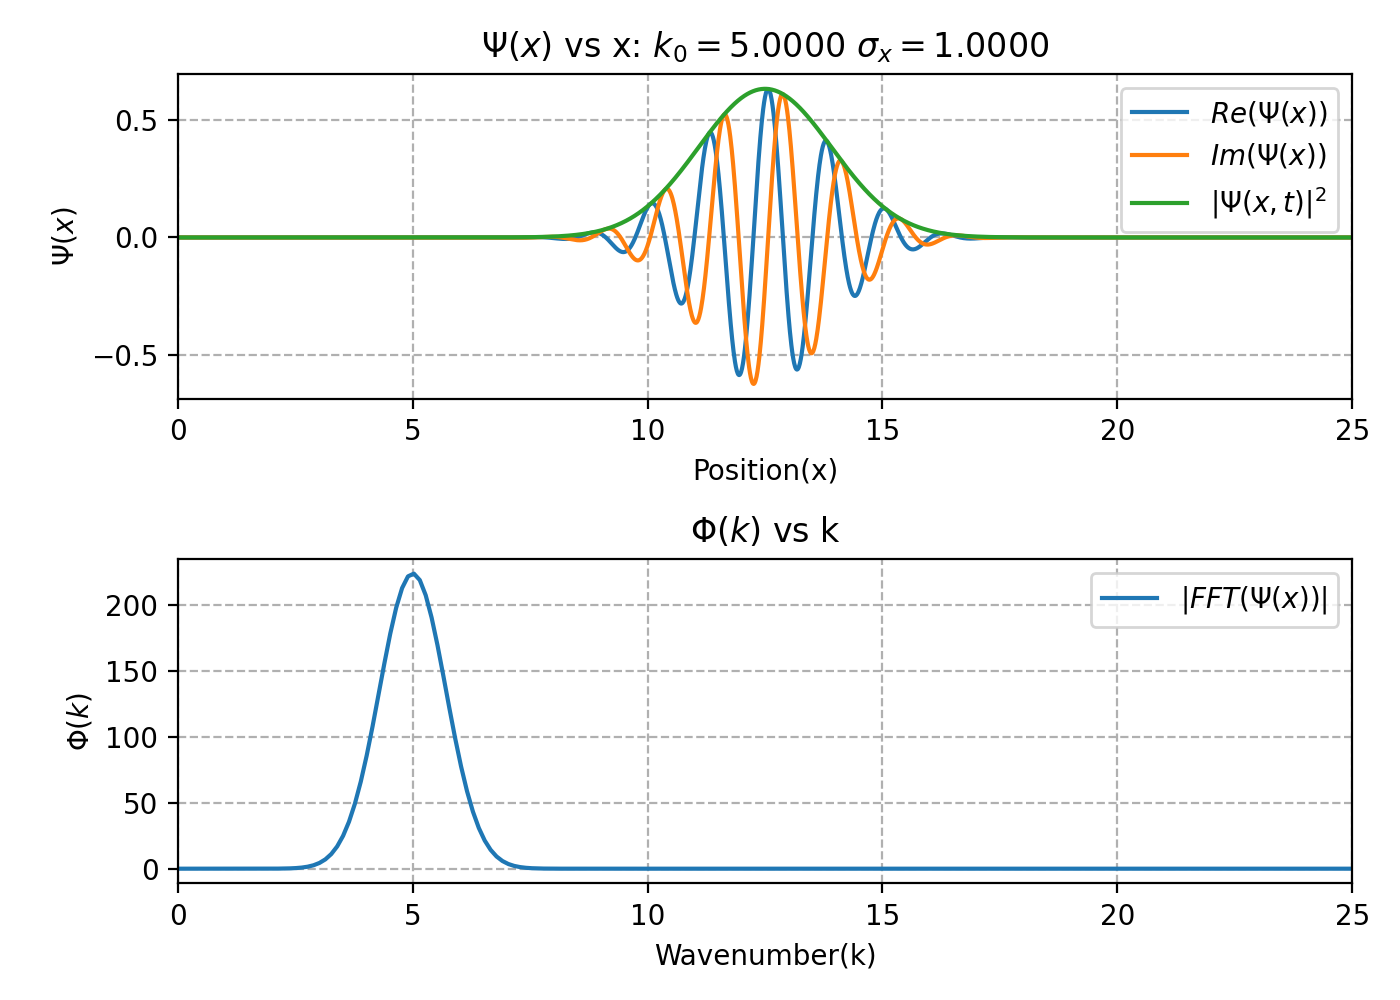

<IPython.core.display.Javascript object>


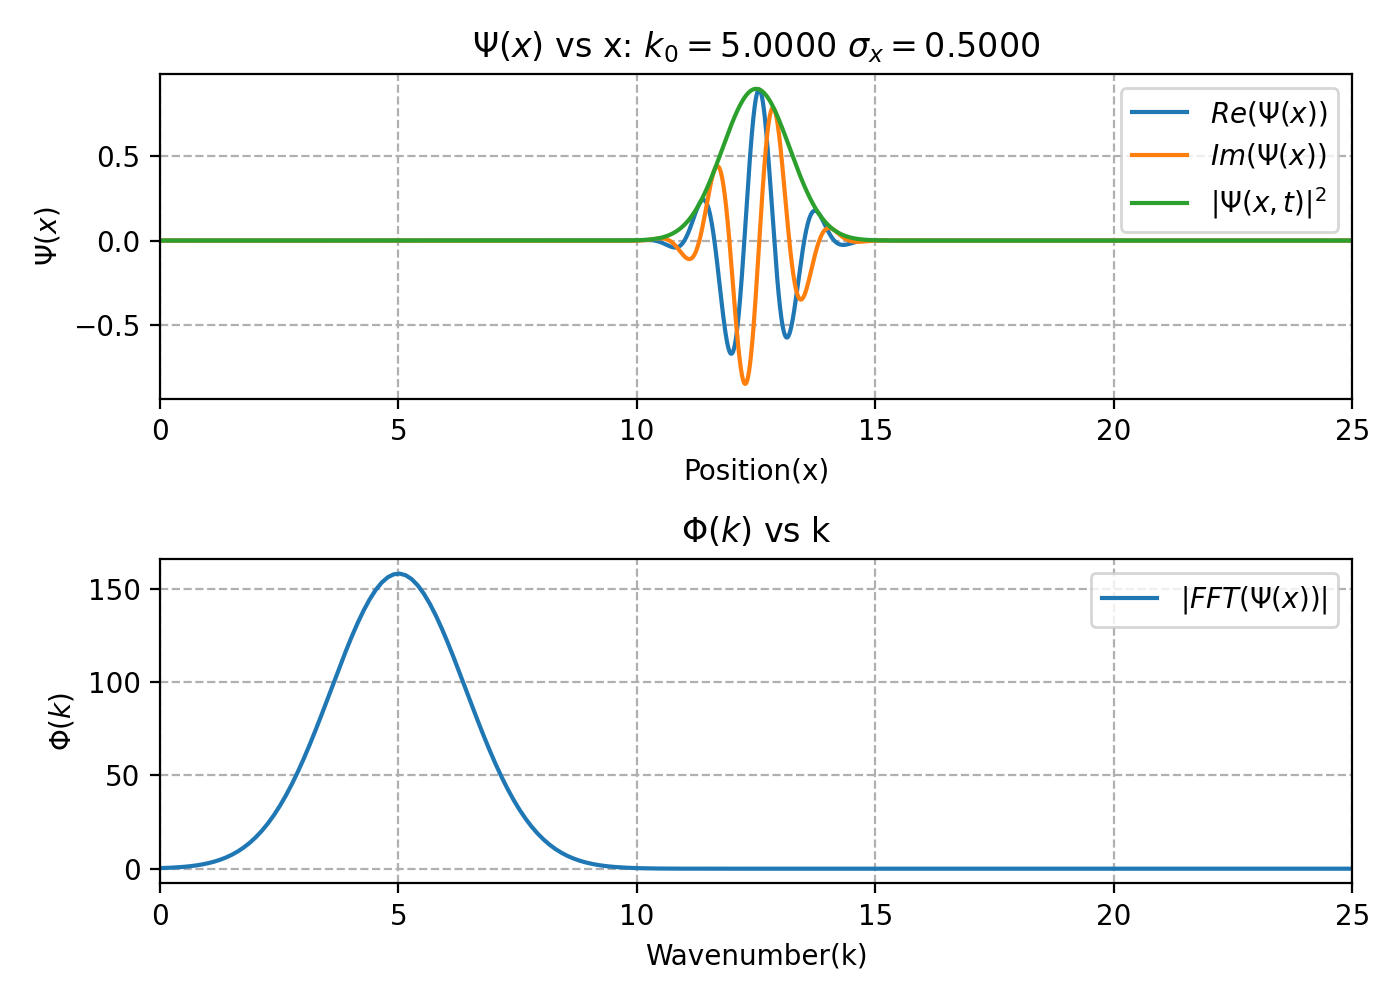

<IPython.core.display.Javascript object>


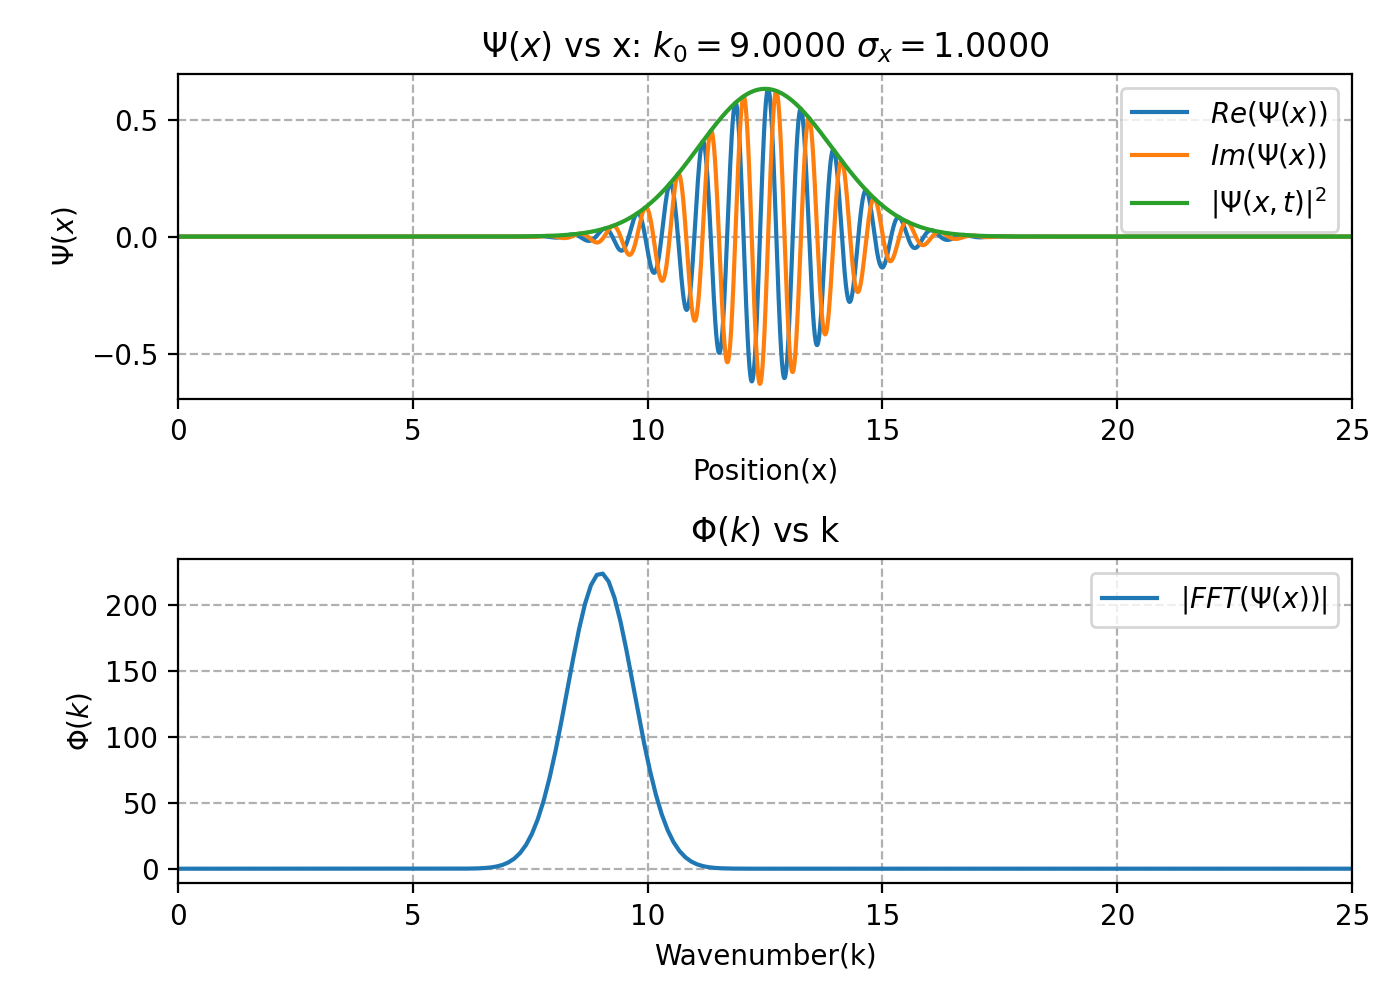

In [23]:
#setting up plots
k_array = np.array([5,5,9])
sig_x = np.array([1,.5,1])

x0 = 12.5

for i in range(3):
    psi = packet(x,k_array[i],x0,sig_x[i])
    f_k = np.fft.fft(psi)
    n = np.int_(psi.size)
    k = 2*np.pi*np.fft.fftfreq(n,dx)
    
    plt.figure(figsize=(7,5))
    ax = plt.subplot(2,1,1)
    ax.set_xlim(0,25)
    kval = k_array[i].astype('int')
    sigval= sig_x[i].astype('float')
    ax.set_title('$\Psi(x)$ vs x: $k_0={:.4f}$ $\sigma_x={:.4f}$'.format(kval,sigval))
    ax.plot(x,psi.real,label='$Re(\Psi(x))$')
    ax.plot(x,psi.imag,label='$Im(\Psi(x))$')
    ax.plot(x,np.abs(psi),label='$|\Psi(x,t)|^2$')
    ax.set_xlabel('Position(x)')
    ax.set_ylabel('$\Psi(x)$')
    ax.grid(linestyle='--')
    plt.legend()
    
    ax = plt.subplot(2,1,2)
    ax.set_xlim(0,25)
    n2 = np.int_(n/2)
    ax.set_title('$\Phi(k)$ vs k')
    ax.plot(k[:n2],np.abs(f_k[:n2]),label='$|FFT(\Psi(x))|$')
    ax.set_xlabel('Wavenumber(k)')
    ax.set_ylabel('$\Phi(k)$')
    ax.grid(linestyle='--')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

_____________________________________________________________________________________
Part 2: (7 points)

In this part we will make a plot with for each of the various initial conditions

- Each case should be a figure with 3 subplots (1 for each $k_0$)
- on each subplot plot the potential, the mean energy $E_{mean}$ with a band showing the $\pm 2\sigma_E$
- The initial wavefunction squared $|\psi(x,0)|^2$ on the line for $E_{mean}$

a) Step Potential, $V_0=40$
- $k_0=7$
- $k_0=9$
- $k_0=10$

b) Barrier Potential $W=.25$, $V_0=40$
- $k_0=7$
- $k_0=9$
- $k_0=10$

c) Barrier Potential $W=1$, $V_0=40$
- $k_0=7$
- $k_0=9$
- $k_0=10$

d) Barrier Potential $W=.25$, $V_0=-20$
- $k_0=7$
- $k_0=9$
- $k_0=10$


____________________________________________________________________________________

<IPython.core.display.Javascript object>


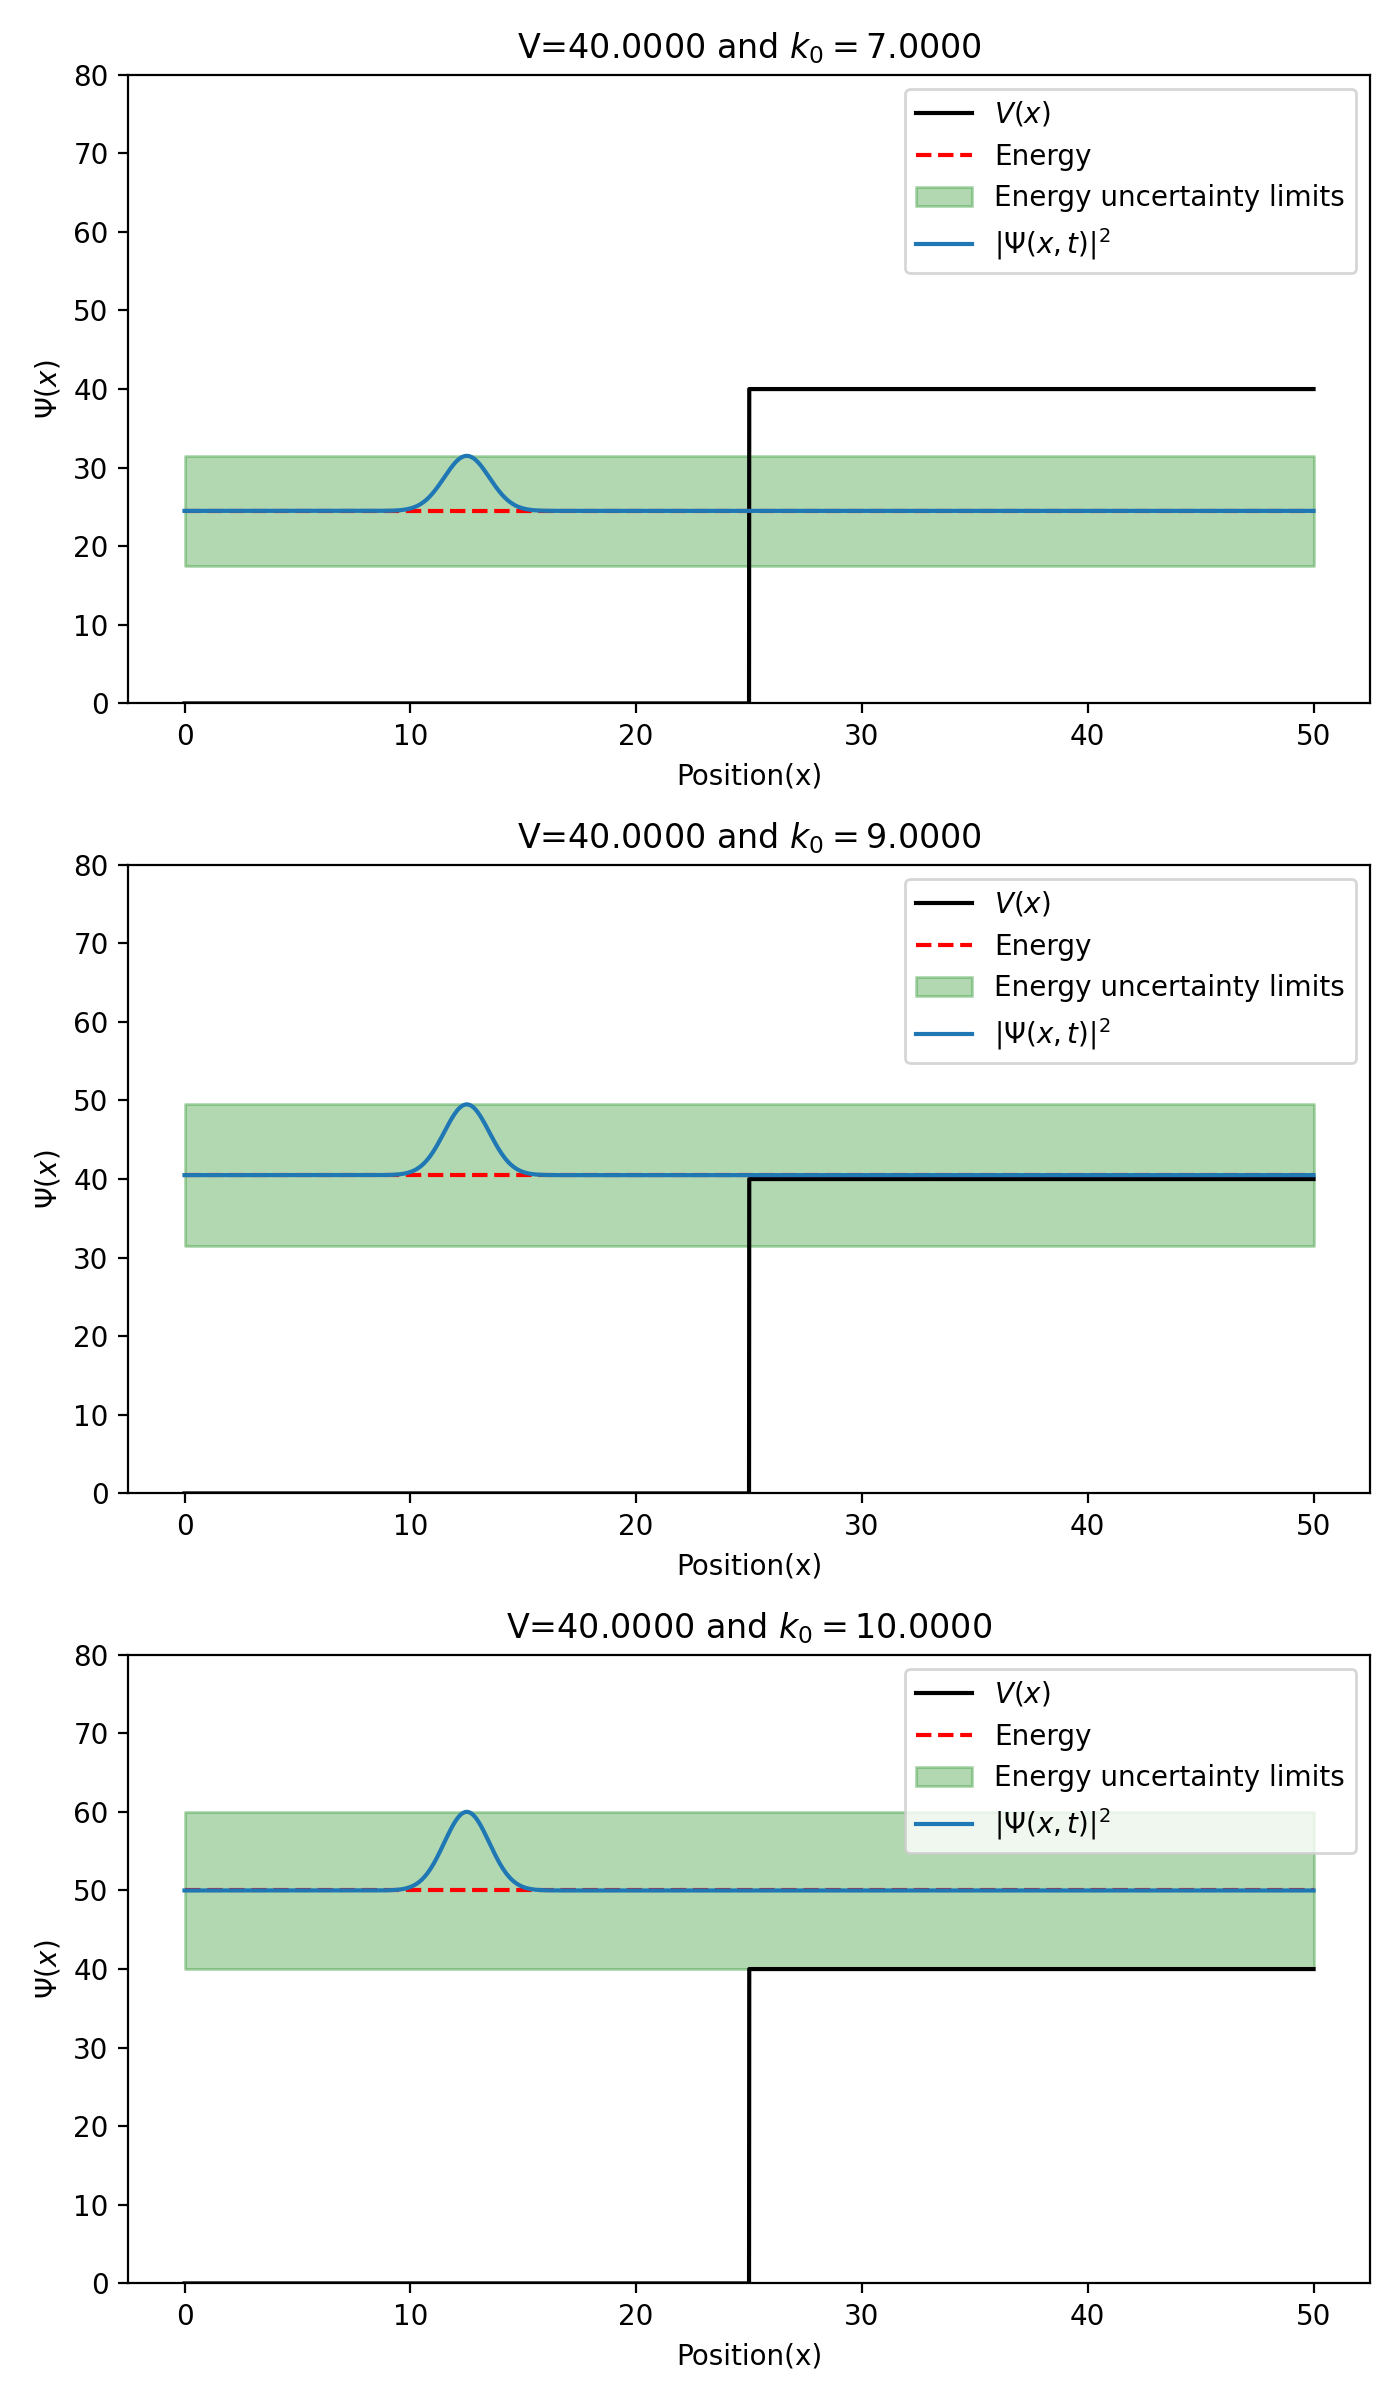

<IPython.core.display.Javascript object>


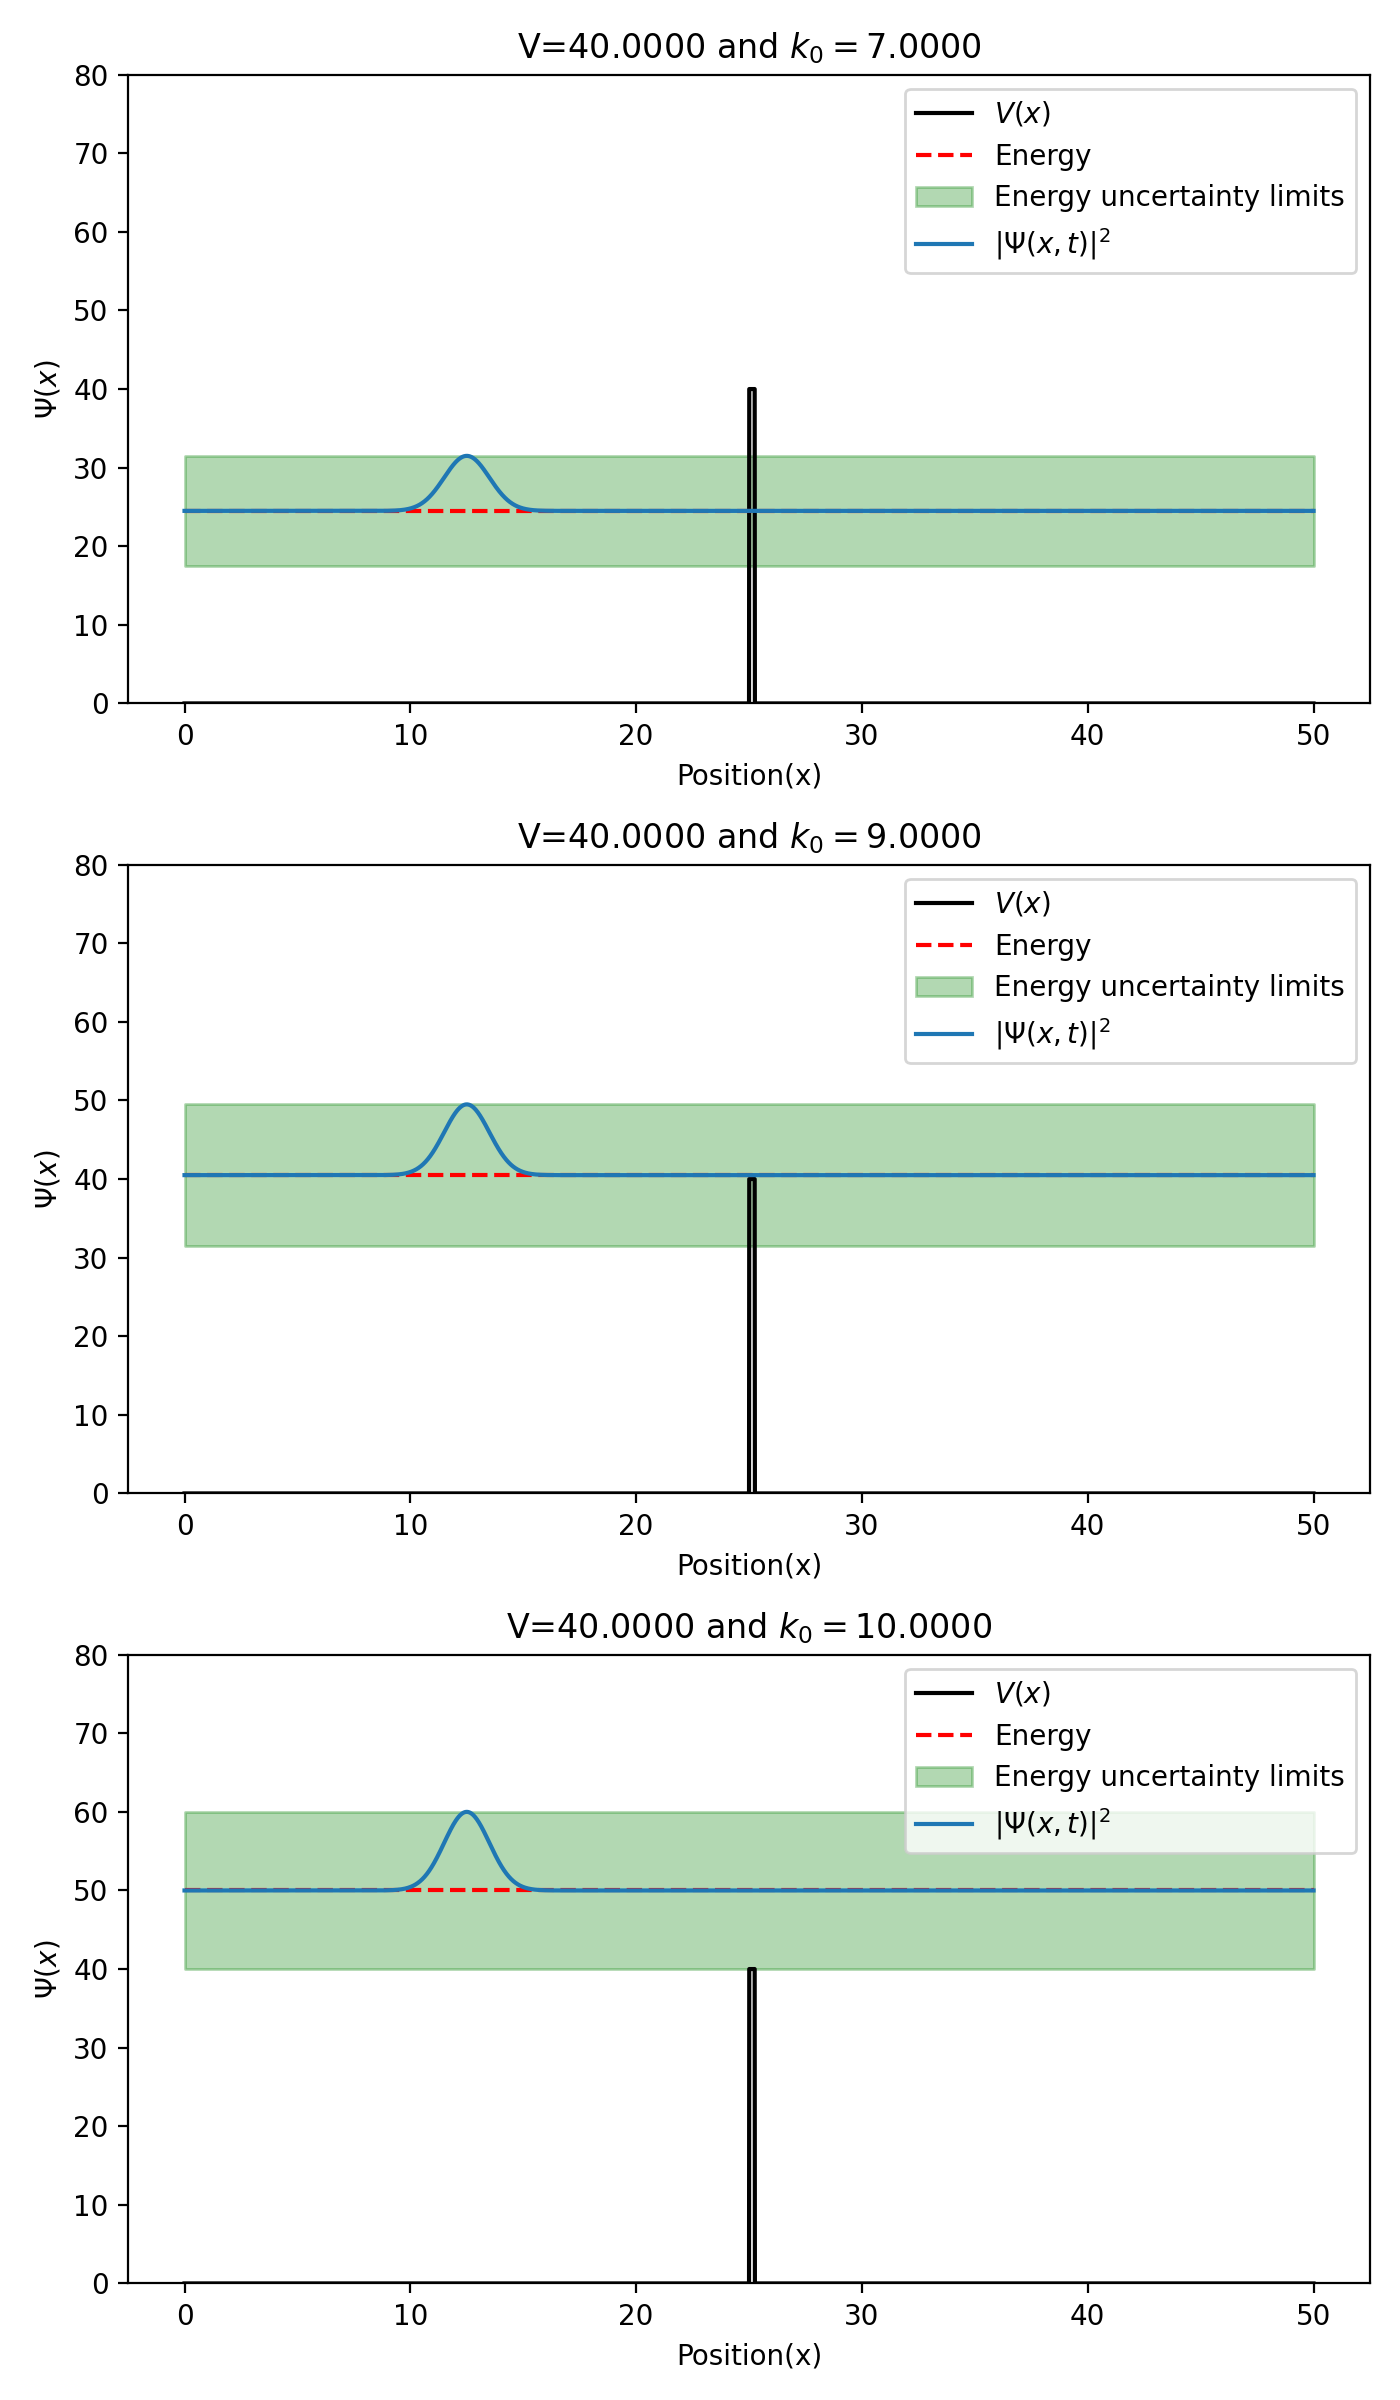

<IPython.core.display.Javascript object>


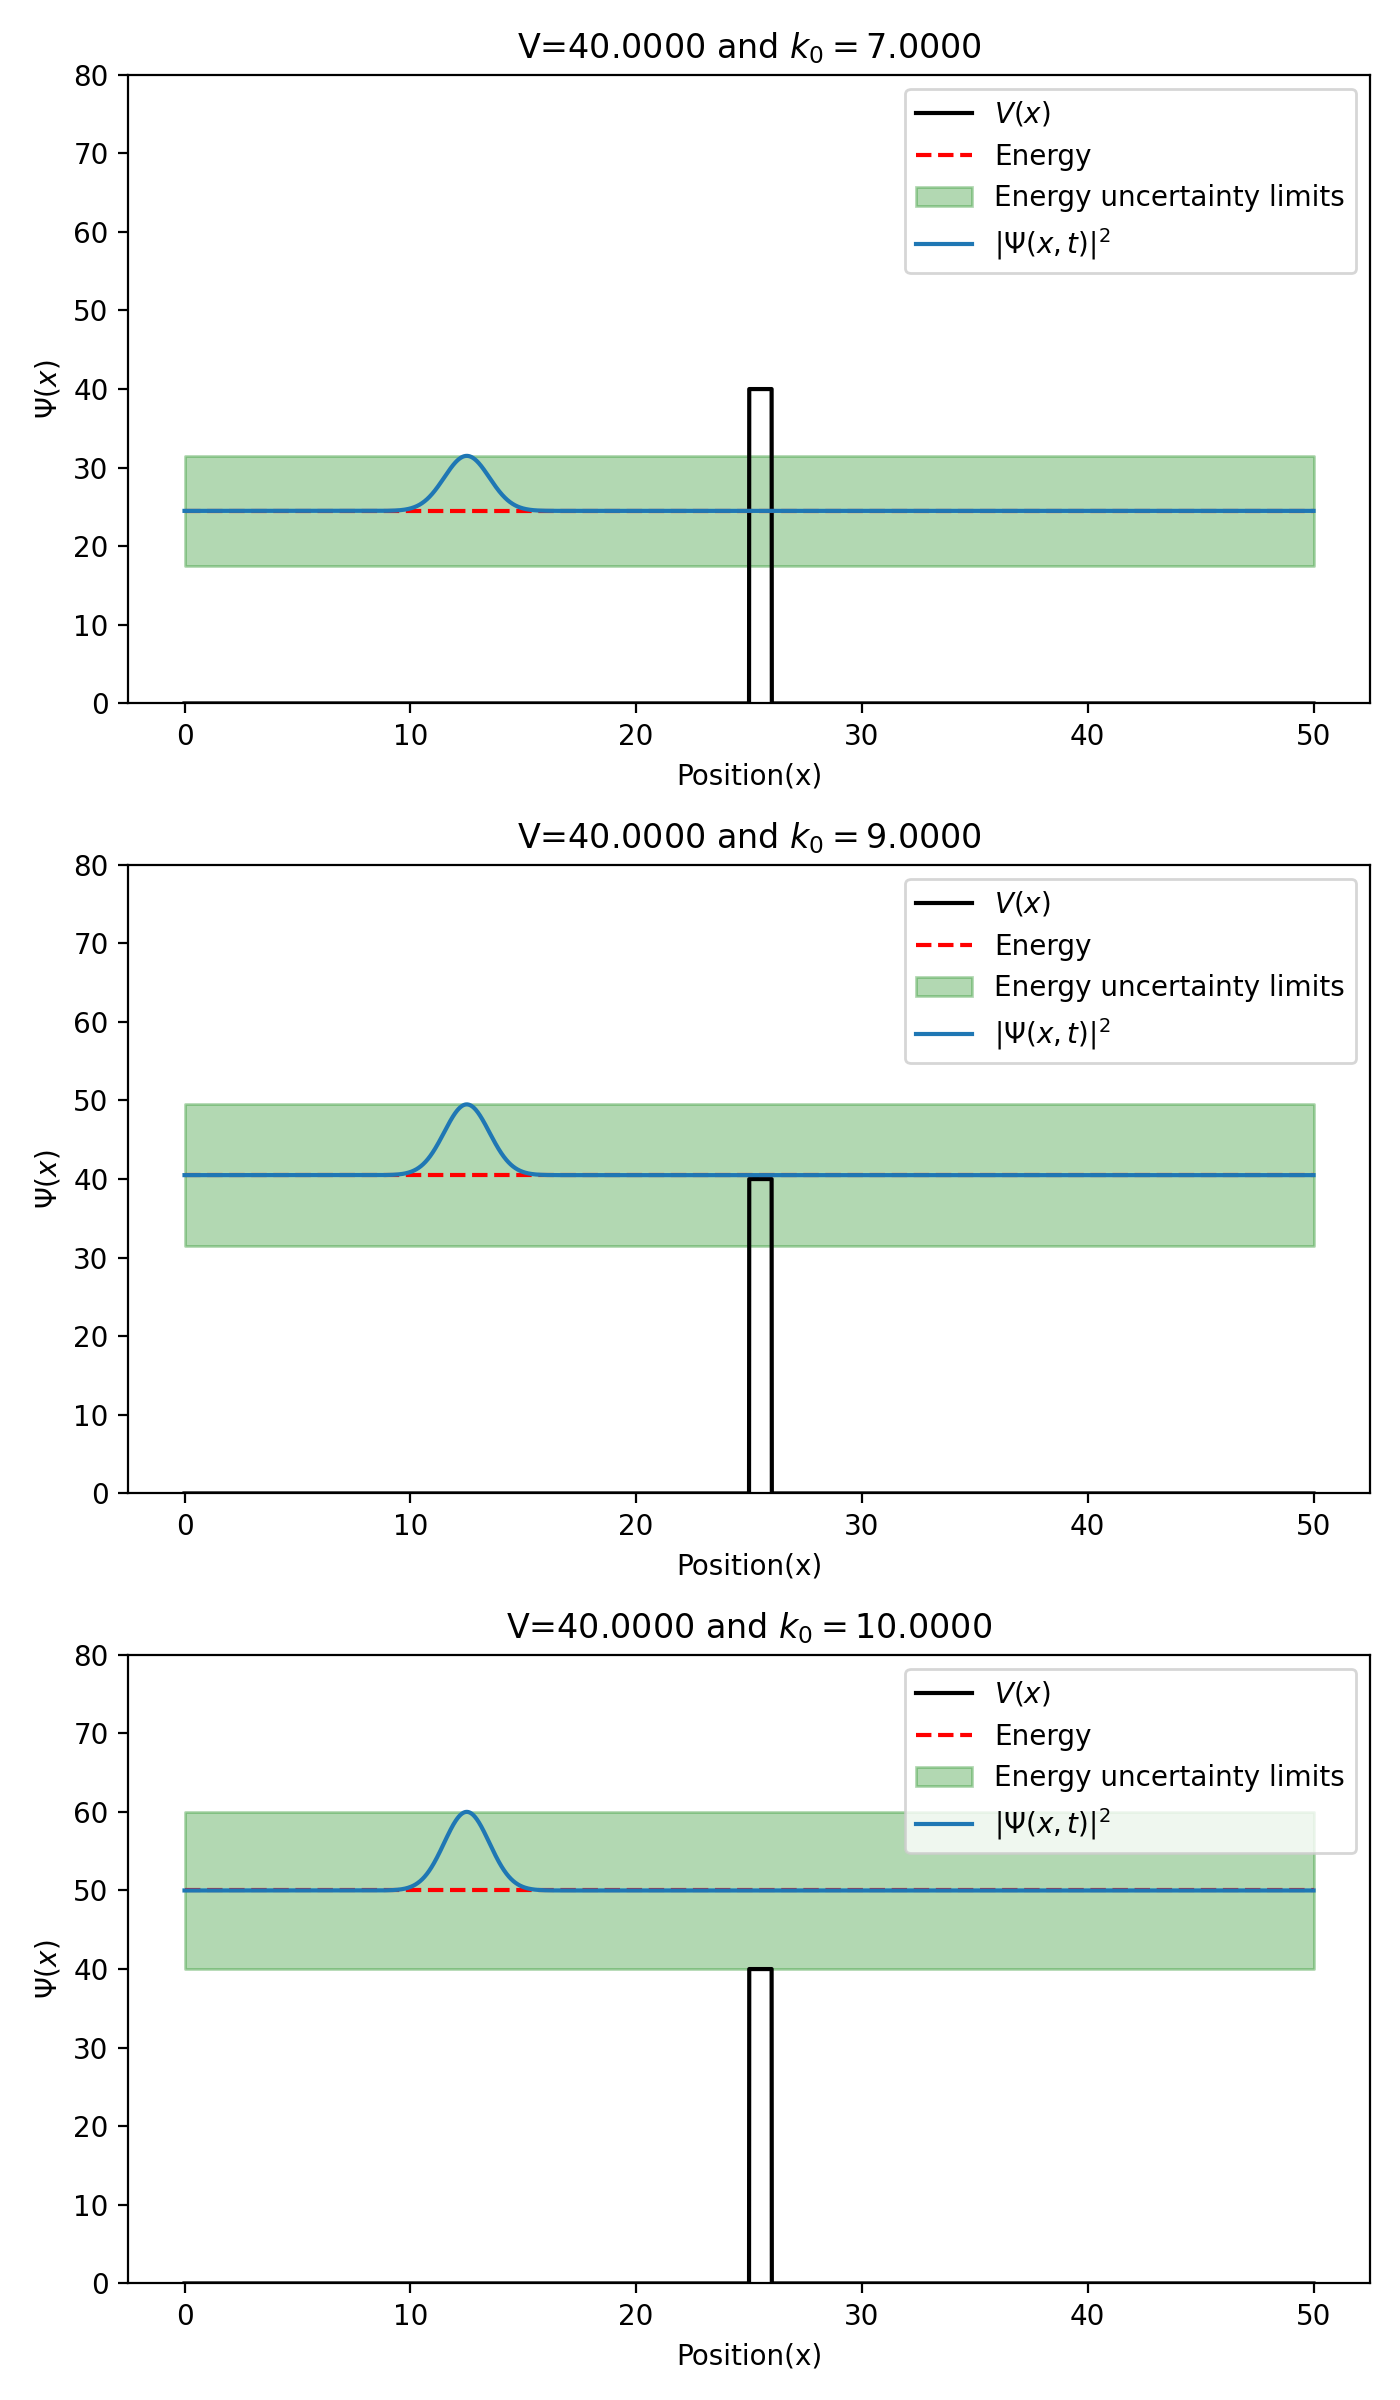

<IPython.core.display.Javascript object>


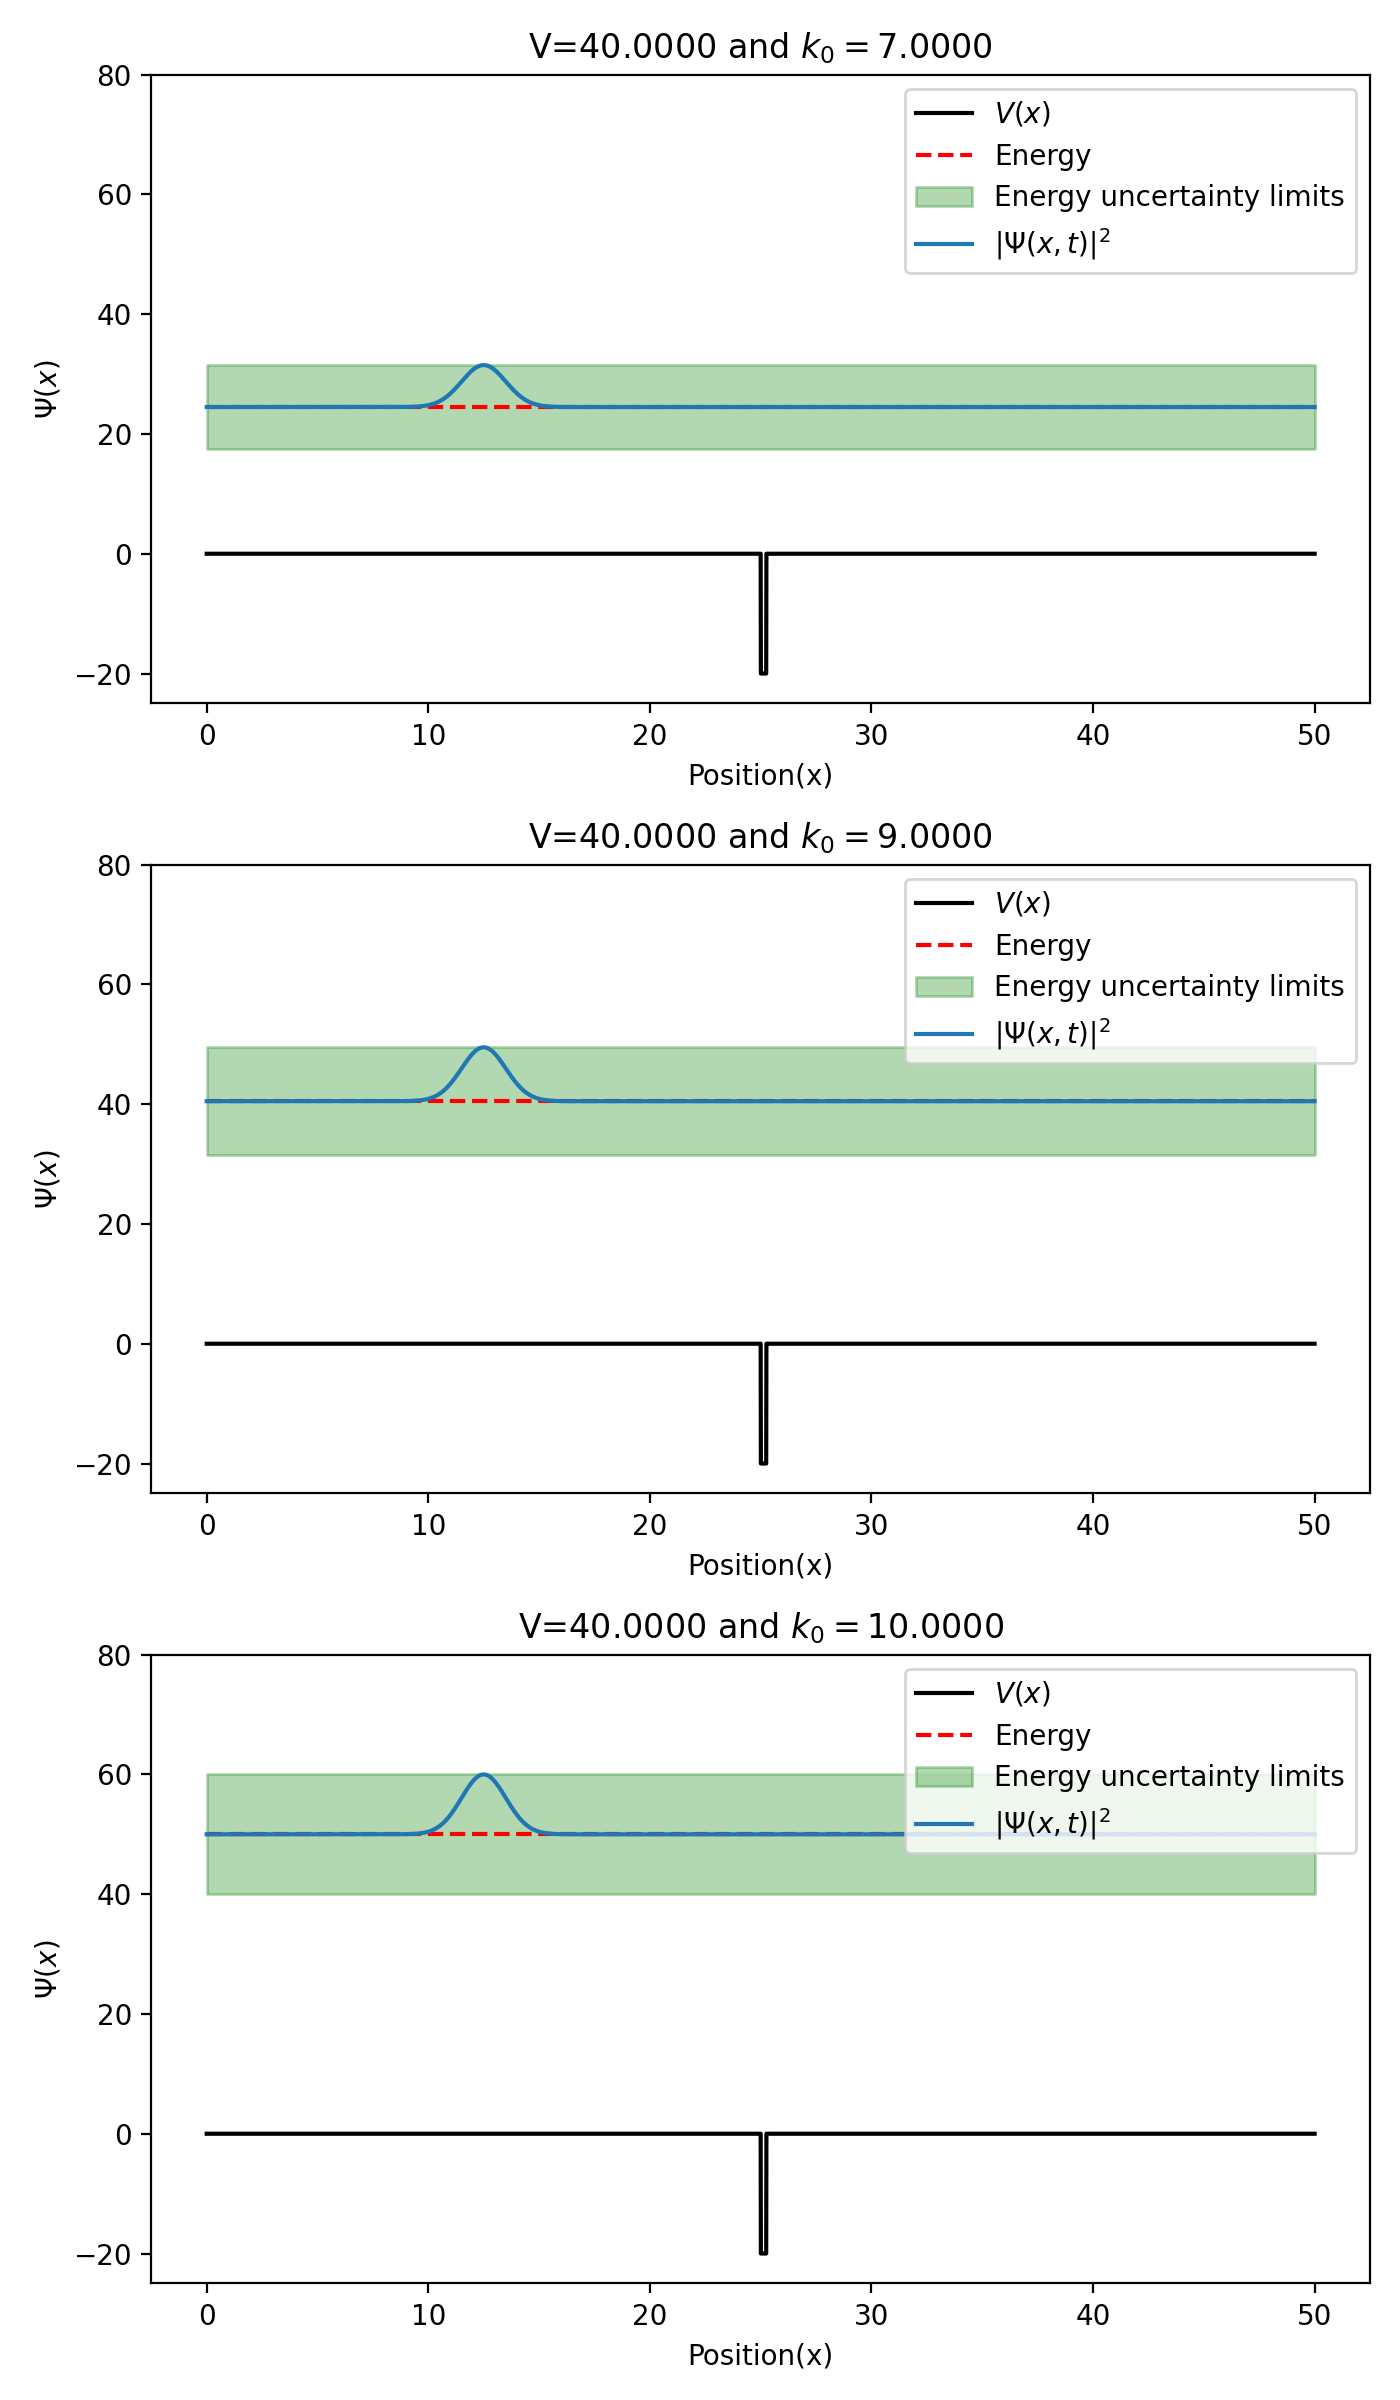

In [25]:
sigma = 1.
x0 = 12.5

k_val = np.array([7,9,10])
v_width = np.array ([50,0.25,1.0,0.25])
v_0 = np.array([40,40,40,-20])

for j in range(4):
    V = potential(x,v_width[j],v_0[j])
    fig,ax = plt.subplots(3,1,figsize=(7,12))
    for i in range(3):
        psi = packet(x,k_array[i],x0,sigma)
        energy,e_ul,e_ll,energy_sigma=energy_parameters(k_val[i],sigma)
        psi0 = packet(x,k_val[i],x0,sigma)
        if j<3:
            ax[i].set_ylim([0,80])
        else:
            ax[i].set_ylim([-25,80])
        potval = v_0[i].astype('int')
        kval=k_val[i].astype('int')
        ax[i].set_title('V={:.4f} and $k_0={:.4f}$'.format(potval,kval))
        ax[i].plot(x,V,color='black', label=r"$V(x)$")
        ax[i].plot([x.min(),x.max()],[energy,energy],color='red',linestyle = '--',label = 'Energy')
        ax[i].fill_between([x.min(),x.max()],[e_ll,e_ll],[e_ul,e_ul],alpha=0.3,color='green',label = 'Energy uncertainty limits')
        psi0_max = (np.abs(psi0**2)).max()
        scale = (e_ul-energy)/psi0_max
        ax[i].plot(x,scale*np.abs(psi)**2+energy,label='$|\Psi(x,t)|^2$')
        ax[i].set_xlabel('Position(x)')
        ax[i].set_ylabel('$\Psi(x)$')
        ax[i].legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()


__________________________________________________________________________________________
Part 3 (9 points)

- write the code to solve the TDSE to get the wave-function vs t given any of the conditions above. 
- make an animation of the wave-function based on the solution
- try it on one or more of the cases above




<IPython.core.display.Javascript object>


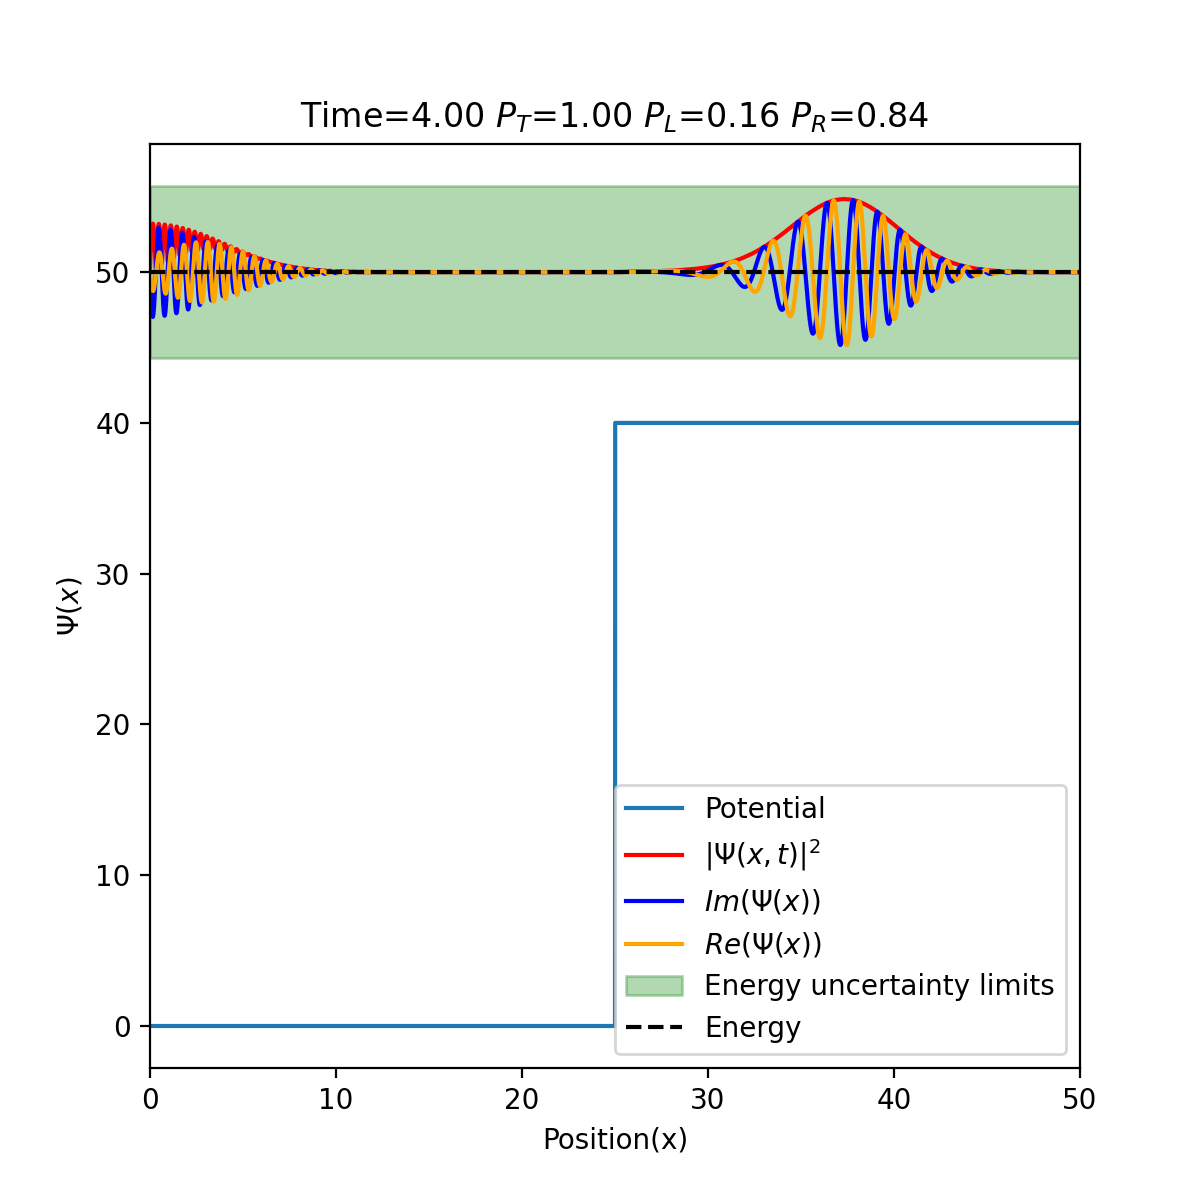

/var/folders/2g/f6b8dk8j10x1d5d4xp9_4knm0000gn/T/ipykernel_7204/1456005633.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([x.min(),x.max()],[energy,energy],'k--',color='black',label='Energy')


In [38]:
from matplotlib import animation

D2 = sparse.diags([1,-2,1],[-1,0,1],shape=(x.size,x.size))/dx**2

def psi_t(t,psi,V):
    return -1j*(-0.5*hbar/m*D2.dot(psi)+V/hbar*psi)

V = potential(x,50,40)
k0 = 10
sigma = 1.75
x0 = 12.5
step = np.int_(np.size(x)/2)

energy,e_ul,e_ll,energy_sigma = energy_parameters(k0,sigma)
psi0 = packet(x,k0,x0,sigma)
sol = integrate.solve_ivp(psi_t,t_span=[t0,t_f],y0=psi0,t_eval=t_eval,method="RK23",args=(V,))

inte = np.empty(t_eval.size)
inte_l = np.empty(t_eval.size)
inte_r = np.empty(t_eval.size)
for j in range(t_eval.size):
    inte[j]=np.sum(np.abs(sol.y[:,j])**2)*dx
    inte_l[j]=np.sum(np.abs(sol.y[:step:,j])**2)*dx
    inte_r[j]=np.sum(np.abs(sol.y[step::,j])**2)*dx
    
fig = plt.figure(figsize=(6,6))
fig.clf()
ax1 = plt.subplot(1,1,1)
psi0_max = (np.abs(psi0)).max()
scale = (e_ul-energy)/psi0_max
ax1.set_xlim(0,x_max)
title = ax1.set_title('')
ax1.plot(x,V,label = 'Potential')
line1, = ax1.plot([],[],'red',label='$|\Psi(x,t)|^2$')
line2, = ax1.plot([],[],'blue',label='$Im(\Psi(x))$')
line3, = ax1.plot([],[],'orange',label='$Re(\Psi(x))$')
plt.fill_between([x.min(),x.max()],[e_ll,e_ll],[e_ul,e_ul],color='green',alpha=0.3,label='Energy uncertainty limits')
ax1.plot([x.min(),x.max()],[energy,energy],'k--',color='black',label='Energy')
ax1.set_xlabel('Position(x)')
ax1.set_ylabel('$\Psi(x)$')
ax1.legend()

    
def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    return line1,line2,line3
      
def animate(i):
    title.set_text(r'Time={:1.2f} $P_T$={:1.2f} $P_L$={:1.2f} $P_R$={:1.2f}'.format(sol.t[i],inte[i],inte_l[i],inte_r[i]))
    line1.set_data(x,energy+scale*np.abs(sol.y[:,i]))
    line2.set_data(x,energy+scale*sol.y[:,i].real)
    line3.set_data(x,energy+scale*sol.y[:,i].imag)
    return line1,line2,line3
    
anim = animation.FuncAnimation(fig,animate,init_func=init, interval=5, blit=True)

Part 4a (1 point)

- for case 2a) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each

_______________________________________________________________________
Observations

V=40

k=7:
T=0.00, R=1.00
k=9:
T=0.32, R=0.68
k=10:
T=0.84, R=0.16
________________________________________________________________________

Part 4b (1 point)

- for case 2b) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each



_______________________________________________________________________
Observations

V=40

k=7:
T=0.00, R=1.00
k=9:
T=0.32, R=0.68
k=10:
T=0.84, R=0.16
________________________________________________________________________

Part 4c (1 point)

- for case 2c) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each




_______________________________________________________________________
Observations


________________________________________________________________________

Part 4d (1 point)

- for case 2d) above run your script for the 3 $k_0$ and see what is happening
- calcuate the 'transmission' and 'reflection' for each


________________________________________________
Observations


______________________________________________